In [14]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import os

In [15]:
# CUDA is not necessary for the examples in this notebook.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [17]:
# Use your own path ;)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [18]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


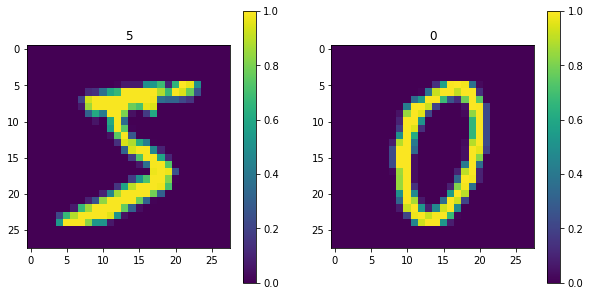

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.colorbar()
plt.title(y_train[0].item());
plt.subplot(1,2,2)
plt.imshow(x_train[1000])
plt.colorbar()
plt.title(y_train[1000].item());

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Tasks
* Train a classifier with fully-connected layers only.
* Train a classifier with convolutions only.
* Train a classifier with convolutions and fully-connected layers.
* Train a denoising network. Note, you have to create some noisy observations first ;)

# 1. Create model

Helpful: https://www.tensorflow.org/guide/keras/custom_layers_and_models

# 3. Choose loss-function and optimizer

# 4. Write train-loop

__Note:__ This time we did not set the environment variable to hide the GPU. Hence, if you have access to a GPU the model will automatically run on GPU.

__PS:__ Don't forget `@tf.function` to speed-up training!

In [21]:
class MyModel_FullyDense(tf.keras.Model):
    def __init__(self):
        super(MyModel_FullyDense, self).__init__()
        
        self.flat_input = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(32, activation='relu')
        self.output_tensor = tf.keras.layers.Dense(10, activation='softmax')
        
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    def call(self, x):
        x = self.flat_input(x)
        x = self.dense(x)
        return self.output_tensor(x)
    
    @tf.function
    def test_step(self, images, labels):
        predictions = self(images, training=False)
        t_loss = self.loss_object(labels, predictions)

        self.test_loss(t_loss)
        self.test_accuracy(labels, predictions)
        
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, predictions)
        
    def train(self, train_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for images, labels in train_ds:
                self.train_step(images, labels)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            print( 'Epoch %d, Loss: %.3f, Accuracy: %.2f%%, Test Loss: %.3f, Test Accuracy: %.2f%%'%(
                epoch+1, self.train_loss.result(), self.train_accuracy.result() * 100, self.test_loss.result(), self.test_accuracy.result() * 100
            ))

In [22]:
class MyModel_FullyConv(tf.keras.Model):
    def __init__(self):
        super(MyModel_FullyConv, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, strides=1, activation='relu') #28-2    = 26
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2,    = 24
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)                            # /2     = 12
        self.conv3 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2     = 10
        # - - - - - - - - - 
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)                            # /2     = 5
        self.conv4 = tf.keras.layers.Conv2D(filters=10, kernel_size=5, strides=1, activation='relu') # -4     = 1
        self.flat_out = tf.keras.layers.Flatten()
        
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.flat_out(x)
        return tf.keras.activations.softmax(x)

    @tf.function
    def test_step(self, images, labels):
        predictions = self(images, training=False)
        t_loss = self.loss_object(labels, predictions)

        self.test_loss(t_loss)
        self.test_accuracy(labels, predictions)
        
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, predictions)
        
    def train(self, train_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for images, labels in train_ds:
                self.train_step(images, labels)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            print( 'Epoch %d, Loss: %.3f, Accuracy: %.2f%%, Test Loss: %.3f, Test Accuracy: %.2f%%'%(
                epoch+1, self.train_loss.result(), self.train_accuracy.result() * 100, self.test_loss.result(), self.test_accuracy.result() * 100
            ))

In [23]:
class MyModel_Mixed(tf.keras.Model):
    def __init__(self):
        super(MyModel_Mixed, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, strides=1, activation='relu') #28-2    = 26
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2,    = 24
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)                            # /2     = 12
        self.conv3 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2     = 10
        # - - - - - - - - - 
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')
        
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
    
    @tf.function
    def test_step(self, images, labels):
        predictions = self(images, training=False)
        t_loss = self.loss_object(labels, predictions)

        self.test_loss(t_loss)
        self.test_accuracy(labels, predictions)
        
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, predictions)
        
    def train(self, train_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for images, labels in train_ds:
                self.train_step(images, labels)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            print( 'Epoch %d, Loss: %.3f, Accuracy: %.2f%%, Test Loss: %.3f, Test Accuracy: %.2f%%'%(
                epoch+1, self.train_loss.result(), self.train_accuracy.result() * 100, self.test_loss.result(), self.test_accuracy.result() * 100
            ))

# 2. Test if model runs

In [24]:
### This shit never worked...
# model.build([784])
# model.summary()

In [25]:
model_fdense = MyModel_FullyDense()
model_fdense.train(train_ds,EPOCHS=5)
model_fdense.summary()

Epoch 1, Loss: 0.342, Accuracy: 90.37%, Test Loss: 0.208, Test Accuracy: 94.24%
Epoch 2, Loss: 0.188, Accuracy: 94.61%, Test Loss: 0.169, Test Accuracy: 95.03%
Epoch 3, Loss: 0.147, Accuracy: 95.76%, Test Loss: 0.149, Test Accuracy: 95.47%
Epoch 4, Loss: 0.125, Accuracy: 96.31%, Test Loss: 0.139, Test Accuracy: 95.95%
Epoch 5, Loss: 0.109, Accuracy: 96.77%, Test Loss: 0.122, Test Accuracy: 96.45%
Model: "my_model__fully_dense_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  25120     
_________________________________________________________________
dense_3 (Dense)              multiple                  330       
Total params: 25,458
Trainable params: 25,450
Non-trainable params: 8
___________________________________

In [26]:
model_fconv = MyModel_FullyConv()
model_fconv.train(train_ds,EPOCHS=5)
model_fconv.summary()

Epoch 1, Loss: 1.949, Accuracy: 27.15%, Test Loss: 1.901, Test Accuracy: 28.17%
Epoch 2, Loss: 1.723, Accuracy: 36.65%, Test Loss: 1.680, Test Accuracy: 38.16%
Epoch 3, Loss: 1.687, Accuracy: 37.69%, Test Loss: 1.675, Test Accuracy: 38.05%
Epoch 4, Loss: 1.681, Accuracy: 37.80%, Test Loss: 1.666, Test Accuracy: 38.45%
Epoch 5, Loss: 1.677, Accuracy: 37.86%, Test Loss: 1.666, Test Accuracy: 38.42%
Model: "my_model__fully_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  10        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple     

In [27]:
model_mixed = MyModel_Mixed()
model_mixed.train(train_ds,EPOCHS=5)
model_mixed.summary()

Epoch 1, Loss: 0.274, Accuracy: 91.60%, Test Loss: 0.124, Test Accuracy: 95.92%
Epoch 2, Loss: 0.077, Accuracy: 97.66%, Test Loss: 0.077, Test Accuracy: 97.30%
Epoch 3, Loss: 0.052, Accuracy: 98.35%, Test Loss: 0.050, Test Accuracy: 98.40%
Epoch 4, Loss: 0.039, Accuracy: 98.78%, Test Loss: 0.052, Test Accuracy: 98.29%
Epoch 5, Loss: 0.029, Accuracy: 99.09%, Test Loss: 0.051, Test Accuracy: 98.48%
Model: "my_model__mixed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  10        
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  100       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple          

# 5. Evaluate

In [28]:
pred_fdense = model_fdense(x_test, training=False)

In [29]:
pred_fconv = model_fconv(x_test, training=False)
pred_fconv[0].numpy().shape

(10,)

In [30]:
pred_mixed = model_mixed(x_test, training=False)

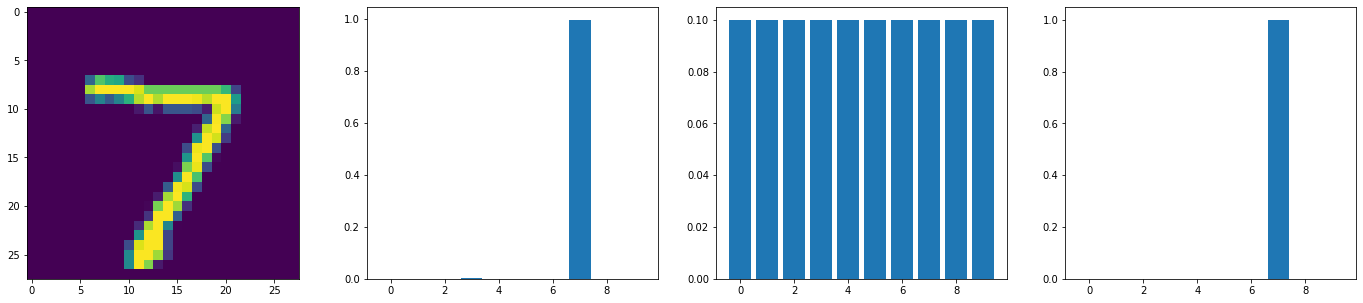

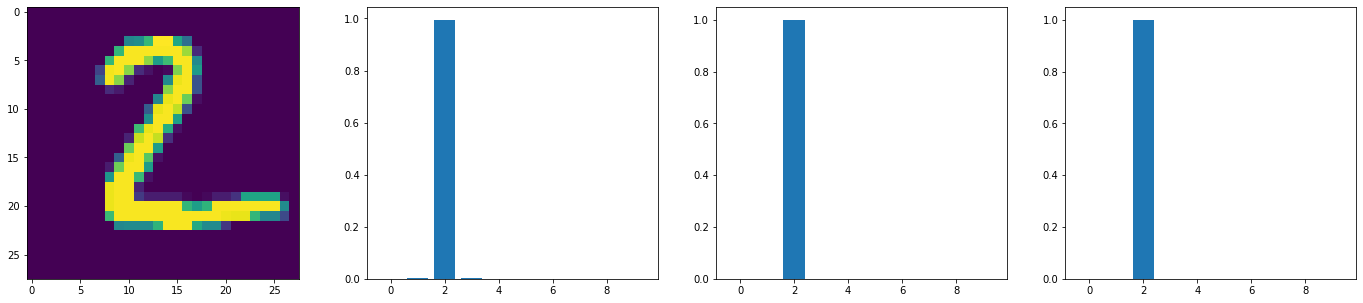

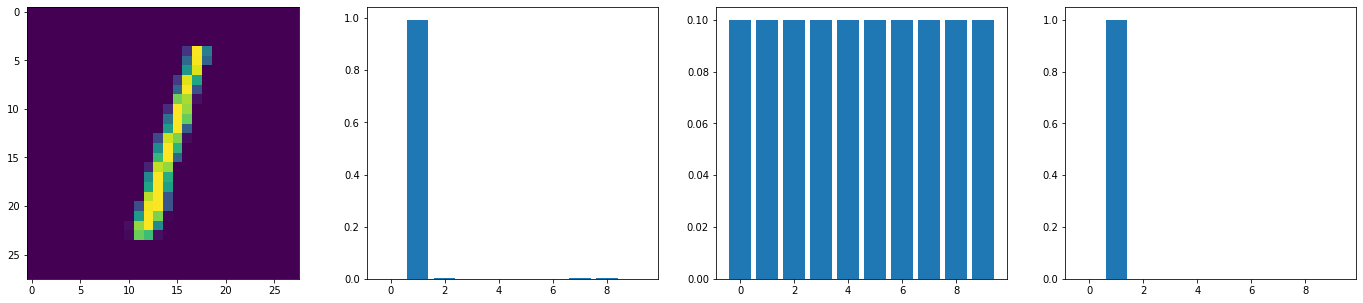

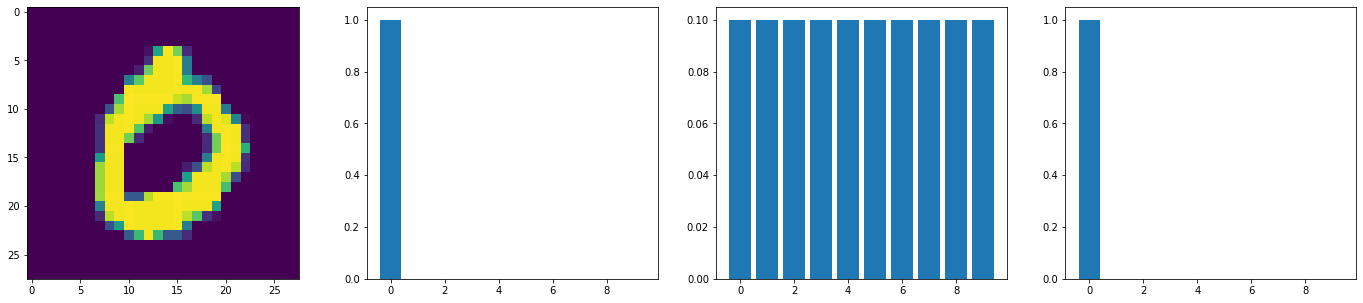

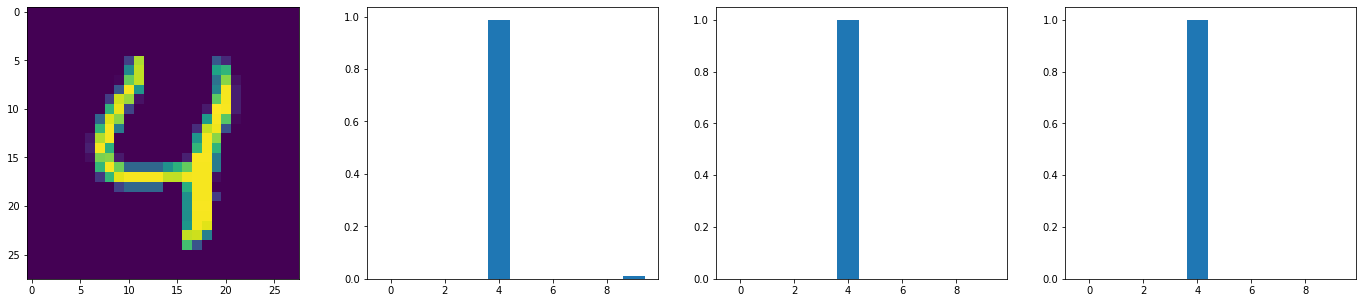

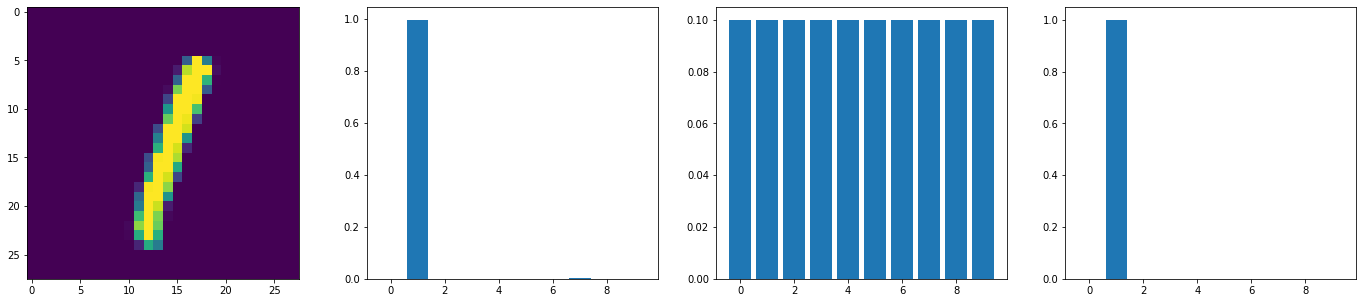

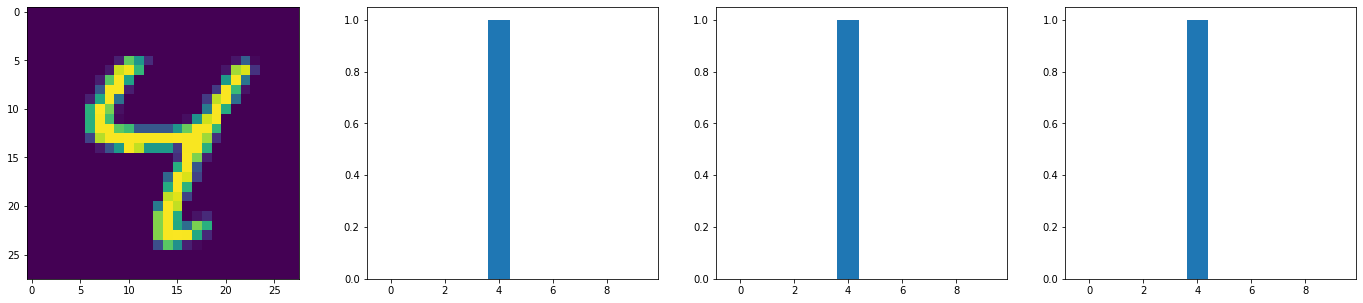

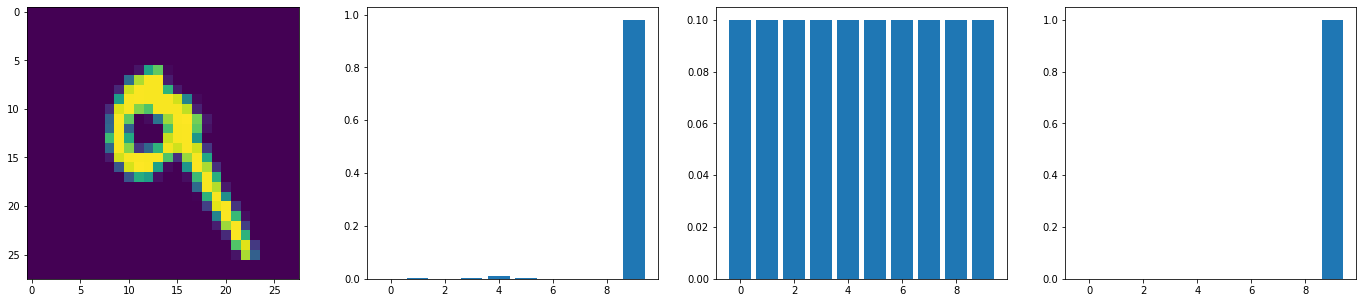

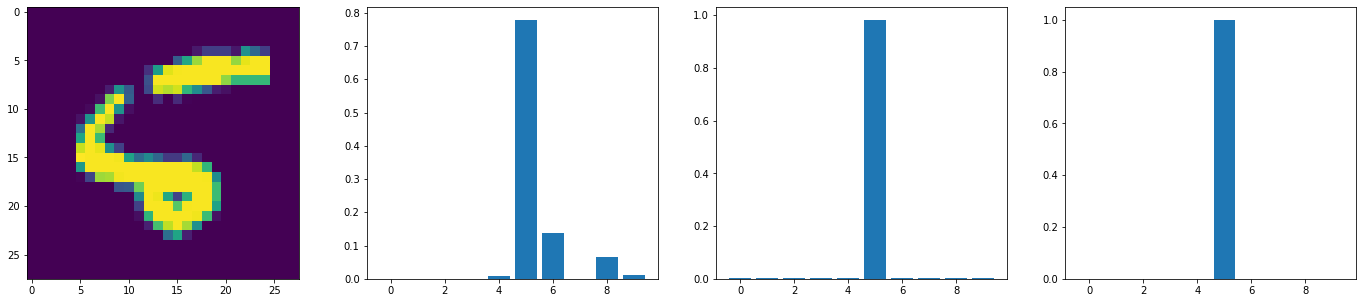

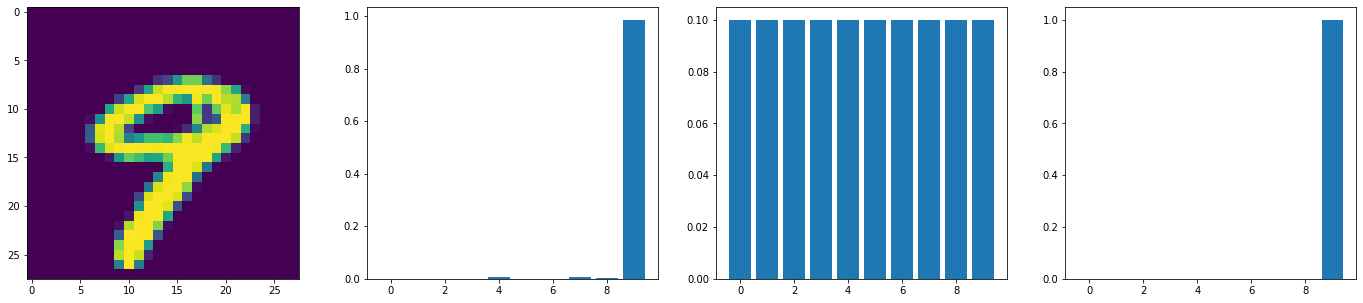

In [31]:
def plot_pred(list_of_preds,idx=0):
    num_preds = len(list_of_preds)

    plt.figure(figsize=(8*num_preds,5))
    plt.subplot(1,1+num_preds,1)
    plt.imshow(x_test[idx])
    for i,preds in enumerate(list_of_preds):
        plt.subplot(1,1+num_preds,2+i)
        plt.bar([0,1,2,3,4,5,6,7,8,9],preds[idx].numpy())

for i in range(10):
    plot_pred([pred_fdense,pred_fconv,pred_mixed],i)

# Denoising Part

### Create Noisy Data

In [32]:
sig_train = x_train
sig_test = x_test

In [33]:
def noise(imgs,sigma=.33):
    return imgs+np.random.normal(0, sigma, size=imgs.shape)
    
noisy_train = noise(sig_train)
noisy_test = noise(sig_test)

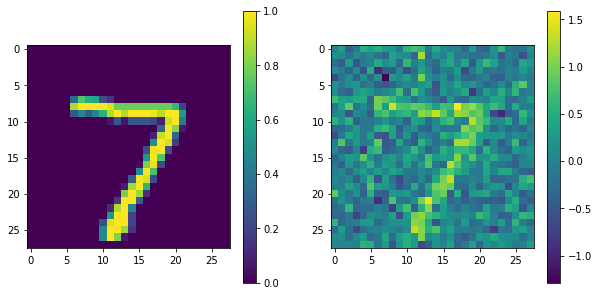

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sig_test[0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(noisy_test[0])
plt.colorbar()

In [35]:
denoise_train_ds = tf.data.Dataset.from_tensor_slices(
    (noisy_train, sig_train)).shuffle(10000).batch(32)

denoise_test_ds = tf.data.Dataset.from_tensor_slices((noisy_test, sig_test)).batch(32)

### Create Network

In [36]:
class MyDenoiseModel(tf.keras.Model):
    def __init__(self):
        super(MyDenoiseModel, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, padding='same', activation='relu') 
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, padding='same', activation='relu') 
        self.conv3 = tf.keras.layers.Conv2D(filters=20, kernel_size=3, padding='same', activation='relu') 
        self.conv4 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, padding='same', activation='relu') 
        
        self.optimizer = tf.keras.optimizers.Adam()
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.test_loss = tf.keras.metrics.Mean(name='test_loss')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)

#     @tf.function
    def test_step(self, images, gt):
        predictions = self(images, training=False)
        t_loss = tf.keras.losses.MSE(gt, predictions)

        self.test_loss(t_loss)
        
#     @tf.function
    def train_step(self, images, gt):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = tf.keras.losses.MSE(gt, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        
    def train(self, train_ds, test_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.test_loss.reset_states()

            for images, gt in train_ds:
                self.train_step(images, gt)

            for test_images, test_gt in test_ds:
                self.test_step(test_images, test_gt)

            print( 'Epoch %d, Loss: %.7f, Test Loss: %.7f'%(
                epoch+1, self.train_loss.result(), self.test_loss.result() ) )

### Train

In [37]:
model_denoise = MyDenoiseModel()
model_denoise.train(denoise_train_ds,denoise_test_ds,EPOCHS=2)
model_denoise.summary()

Epoch 1, Loss: 0.0108519, Test Loss: 0.0062852
Epoch 2, Loss: 0.0061106, Test Loss: 0.0059010
Model: "my_denoise_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            multiple                  10        
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  100       
_________________________________________________________________
conv2d_9 (Conv2D)            multiple                  1820      
_________________________________________________________________
conv2d_10 (Conv2D)           multiple                  181       
Total params: 2,115
Trainable params: 2,111
Non-trainable params: 4
_________________________________________________________________


### Evaluate

In [38]:
denoised = model_denoise(noisy_test, training=False)

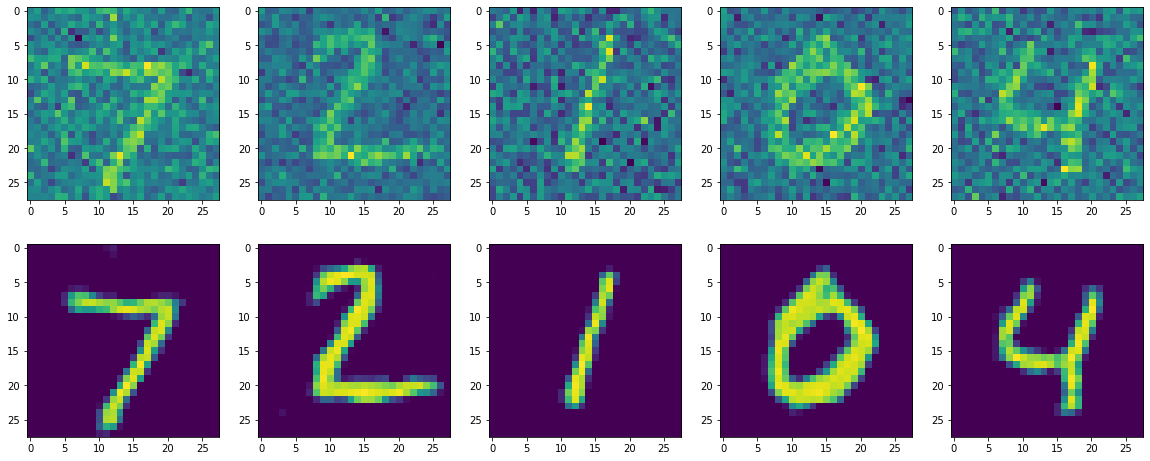

In [39]:
plt.figure(figsize=(20,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    plt.imshow(noisy_test[i])
for i in range(5):
    plt.subplot(2,5,6+i)
    plt.imshow(denoised[i])